Final Accuracy: 0.929553264604811


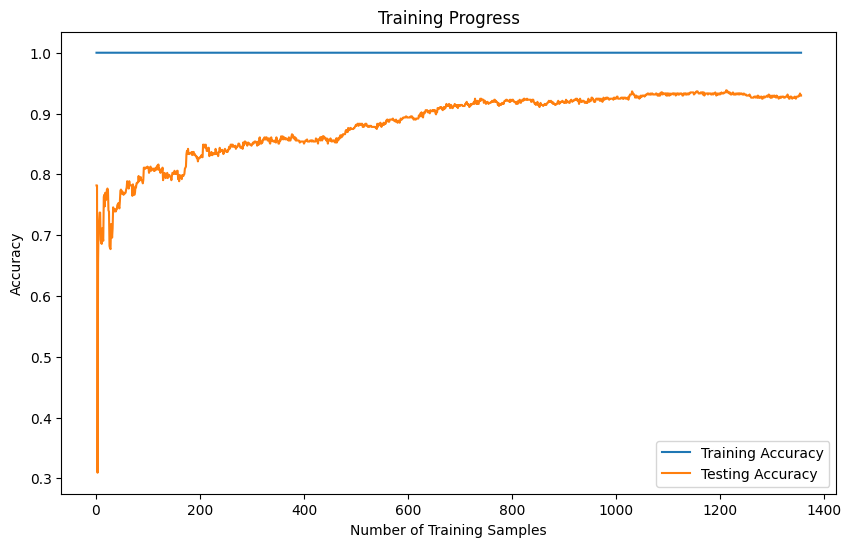

Final Accuracy: 0.929553264604811
 mean squared error: -0.06267636205773822
Cross-validation score: 0.9321533923303835
Precision: 0.9387755102040817
Recall: 0.7244094488188977
F1-score: 0.8177777777777778


In [ ]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# Load the data
bitcoin_prices = pd.read_csv("/content/BTC-USD.csv", index_col=["Date"], parse_dates=True)
ethereum_prices = pd.read_csv("/content/ETH-USD.csv", index_col=["Date"], parse_dates=True)

# Merge the data
data = pd.merge(bitcoin_prices[['Close']], ethereum_prices[['Close']], on='Date')

# Impute the missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=['Bitcoin_Close', 'Ethereum_Close'])

# Calculate the spread and spread statistics
data_imputed['Spread'] = data_imputed['Bitcoin_Close'] - data_imputed['Ethereum_Close']
data_imputed['Spread_mean'] = data_imputed['Spread'].rolling(window=30).mean()
data_imputed['Spread_std'] = data_imputed['Spread'].rolling(window=30).std()
data_imputed['Spread_Narrowing'] = np.where(data_imputed['Spread'] < (data_imputed['Spread_mean'] - data_imputed['Spread_std']), 1, 0)

# Order the features by importance
data_imputed = data_imputed[['Spread_mean', 'Spread', 'Ethereum_Close', 'Bitcoin_Close', 'Spread_std', 'Spread_Narrowing']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_imputed[['Spread_mean', 'Spread', 'Ethereum_Close', 'Bitcoin_Close', 'Spread_std']],
                                                     data_imputed['Spread_Narrowing'],
                                                     test_size=0.3,
                                                     random_state=35)

# Define a pipeline for preprocessing the data and training the model
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
])

# Preprocess the training and testing data using the pipeline
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'criterion': ['gini', 'entropy']
}

# Initialize the grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=35), param_grid, cv=5, scoring='accuracy')

# Fit the grid search
grid_search.fit(X_train_processed, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
model = RandomForestClassifier(**best_params, random_state=35)
model.fit(X_train_processed, y_train)

# Evaluate the model
accuracy = model.score(X_test_processed, y_test)
print("Final Accuracy:", accuracy)
#  learning rate
learning_rate = 0.0001

# Use the 'entropy' criterion for classification with cross-entropy loss
model.set_params(criterion='entropy')


for epoch in range(200):
  model.fit(X_train_processed, y_train)


def evaluate_model(model, X_train, y_train, X_test, y_test):

  # Calculate the loss and accuracy on the training data
  train_loss = model.loss(X_train, y_train)
  train_accuracy = model.score(X_train, y_train)

  # Calculate the loss and accuracy on the validation data
  val_loss = model.loss(X_test, y_test)
  val_accuracy = model.score(X_test, y_test)

  # Print the loss, learning rate, and accuracy
  print(f"Epoch: {epoch + 1}")
  print("Loss:", train_loss)
  print("Learning rate:", learning_rate)
  print("Accuracy:", train_accuracy)

  print("Validation loss:", val_loss)
  print("Validation accuracy:", val_accuracy)


  return train_loss, train_accuracy, val_loss, val_accuracy


# Training Progress Visualization
train_accuracy = []
test_accuracy = []
for i in range(1, len(X_train_processed) + 1):
    model.fit(X_train_processed[:i], y_train[:i])
    y_train_pred = model.predict(X_train_processed[:i])
    y_test_pred = model.predict(X_test_processed)
    train_accuracy.append(accuracy_score(y_train[:i], y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train_processed) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(X_train_processed) + 1), test_accuracy, label='Testing Accuracy')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Progress')
plt.show()

# Evaluate the final model
accuracy = model.score(X_test_processed, y_test)
print("Final Accuracy:", accuracy)

# Calculate the mean squared error
cv_mse = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the mean squared error and cross validation score
print(" mean squared error:", np.mean(cv_mse))
print("Cross-validation score:", cross_val_score(model, X_train_processed, y_train, cv=4).mean())

# Calculate the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, model.predict(X_test_processed))
precision = precision_score(y_test, model.predict(X_test_processed))
recall = recall_score(y_test, model.predict(X_test_processed))
f1 = f1_score(y_test, model.predict(X_test_processed))

# Print the accuracy, precision, recall, and F1-score

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [ ]:
# Trading signals based on predictions
predictions = model.predict(X_test_processed)

# Calculate the Sharpe ratio and Sortino ratio
closing_prices = data_imputed[['Bitcoin_Close', 'Ethereum_Close']]
returns = closing_prices.pct_change()

# Calculate daily returns
daily_returns = closing_prices.pct_change()

# Calculate the Sharpe ratio
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns)

# Calculate the Sortino ratio
sortino_ratio = np.mean(daily_returns[daily_returns > 0]) / np.std(daily_returns[daily_returns < 0])

# Print the Sharpe ratio and Sortino ratio
print("Sharpe ratio:", sharpe_ratio)
print("Sortino ratio:", sortino_ratio)

Sharpe ratio: Bitcoin_Close     0.067159
Ethereum_Close    0.053023
dtype: float64
Sortino ratio: Bitcoin_Close     1.075068
Ethereum_Close    0.850703
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [ ]:
# Define transaction fee percentage and market impact percentage
transaction_fee_percent = 0.01
market_impact_percent = 0.02

# Define a function to execute trades
def execute_trade(trade_type, trade_size):
    # ... Perform trade execution logic ...
    print(f"Executing trade: {trade_type}, size: {trade_size}")

# Define trade size
trade_size = 100

# Calculate transaction costs and slippage
def calculate_transaction_costs(trade_size, transaction_fee_percent):
    transaction_fee = trade_size * transaction_fee_percent
    return transaction_fee

def calculate_slippage(trade_size, market_impact_percent):
    slippage = trade_size * market_impact_percent
    return slippage

# Apply transaction costs and slippage to trading signals
for i in range(len(predictions)):
    if predictions[i] == 1:  # Buy signal
        transaction_fee = calculate_transaction_costs(trade_size, transaction_fee_percent)
        slippage = calculate_slippage(trade_size, market_impact_percent)
        adjusted_trade_size = trade_size - transaction_fee - slippage
        execute_trade('BUY', adjusted_trade_size)
    elif predictions[i] == 0:  # Sell signal
        transaction_fee = calculate_transaction_costs(trade_size, transaction_fee_percent)
        slippage = calculate_slippage(trade_size, market_impact_percent)
        adjusted_trade_size = trade_size - transaction_fee - slippage
        execute_trade('SELL', adjusted_trade_size)


Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: BUY, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: BUY, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: BUY, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: BUY, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: BUY, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: BUY, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: SELL, size: 97.0
Executing trade: BUY